In [1]:
#default_exp ethnicity_icao

In [1]:
#export
from fastai import *
from fastai.vision import *
from pathlib import PosixPath
import cv2
from fastai.callbacks.hooks import *
from fastai.callbacks import *
from fastai.utils.mem import *
from facelib.core import save_inference, load_inference

from torchvision.models import vgg16_bn
from torchvision import models as torchmodels

def save_torch_inference(model, path):
    torch.save(model.state_dict(), path)
    
def load_torch_inference(model, path, device=torch.device('cpu')):
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

In [11]:
laofiw_images_dir = Path('/data/faces/LAOFIW/images/')
images_dir = Path('../data/icao/ethnicity/')

In [14]:
from facenet_pytorch import MTCNN
mtcnn = MTCNN(
    image_size=224, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    device='cuda'
)

from torchvision import datasets
class ImagesWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super().__getitem__(index)
        path = self.imgs[index][0]
        return (original_tuple + (path,))

dataset = ImagesWithPath(str(laofiw_images_dir.parent))
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=lambda x: x[0], num_workers=1)

In [16]:
def create_cropped_images():
    not_found_names = []
    for x, y, path in progress_bar(loader):
        name = Path(path).name
        ethnicity = name.split('_')[-2]
        try:Image(mtcnn(x)/255.).save(str(images_dir/ethnicity/name))
        except: not_found_names.append(Path(path).name)
    return not_found_names
not_found_names = create_cropped_images()
# not_found_names = list(filter(lambda p: not (images_dir/p).exists(), [path.name for path in get_image_files(laofiw_images_dir)]))
len(not_found_names)

63

# Data

In [20]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0., max_rotate=7)

In [18]:
def get_data(src, size, tfms=get_transforms(), bs=4):
    data = (src.transform(tfms, size=size)
            .databunch(bs=bs)
            .normalize(imagenet_stats))
    return data

In [34]:
src = (ImageList.from_folder('../data/icao/ethnicity/').split_by_rand_pct(0.1, seed=42).label_from_folder())
data = get_data(src, 224, bs=64, tfms=tfms)
data

ImageDataBunch;

Train: LabelList (9202 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
black,black,black,black,black
Path: ../data/icao/ethnicity;

Valid: LabelList (1022 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
indian,white,indian,white,chinese
Path: ../data/icao/ethnicity;

Test: None

In [37]:
# acc_02 = partial(accuracy_thresh, thresh=0.2)
# f_score = partial(fbeta, thresh=0.2)
learner = cnn_learner(data, models.resnet34, metrics=[accuracy])
learner.data = get_data(src, 224, bs=64, tfms=tfms)

In [38]:
learner.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.314048,0.885725,0.683953,00:21
1,0.939385,0.734266,0.726027,00:21
2,0.801792,0.668749,0.747554,00:21
3,0.710111,0.613792,0.777887,00:22
4,0.640663,0.633869,0.761252,00:21
5,0.599438,0.576393,0.777887,00:21
6,0.602609,0.590627,0.764188,00:21
7,0.545248,0.587165,0.784736,00:21
8,0.526569,0.580219,0.788650,00:21
9,0.505750,0.568912,0.788650,00:21


In [39]:
learner.data = get_data(src, 224, bs=8, tfms=tfms)
learner.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.772484,0.624806,0.785714,00:34
1,0.753929,0.619839,0.777887,00:34
2,0.742179,0.607048,0.777887,00:34
3,0.798650,0.588810,0.793542,00:34
4,0.716045,0.561118,0.804305,00:34
5,0.611139,0.584481,0.787671,00:34
6,0.723178,0.576083,0.785714,00:34
7,0.691158,0.567634,0.796477,00:34
8,0.663454,0.563639,0.803327,00:34
9,0.685350,0.596208,0.777887,00:34


In [40]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

In [41]:
interp.most_confused()

[('white', 'indian', 65),
 ('chinese', 'indian', 41),
 ('chinese', 'white', 21),
 ('indian', 'white', 21),
 ('white', 'chinese', 17),
 ('black', 'indian', 15),
 ('indian', 'chinese', 15),
 ('black', 'white', 8),
 ('chinese', 'black', 8),
 ('indian', 'black', 8),
 ('white', 'black', 5),
 ('black', 'chinese', 3)]

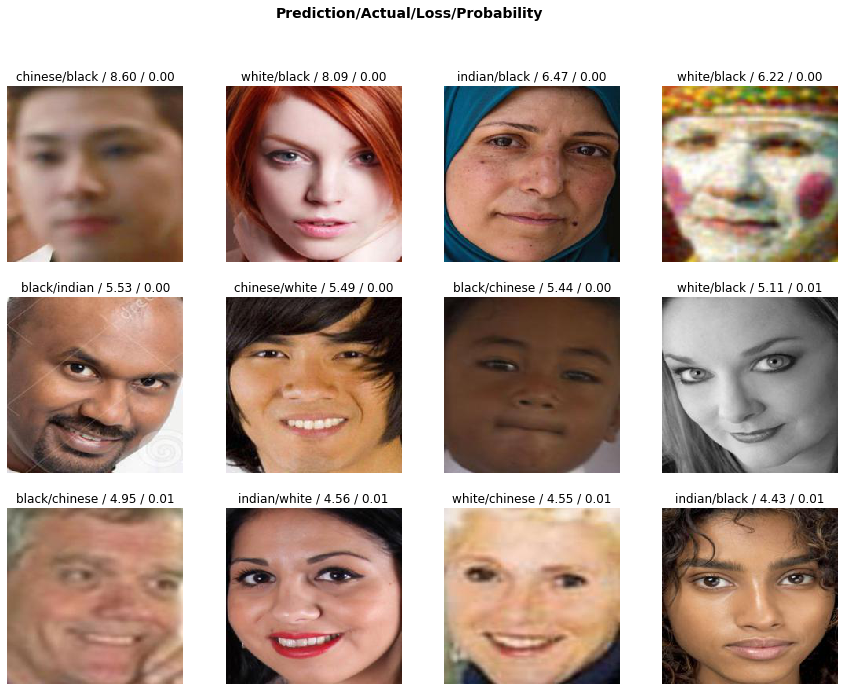

In [44]:
interp.plot_top_losses(3*4, figsize=(15,11), largest=True)

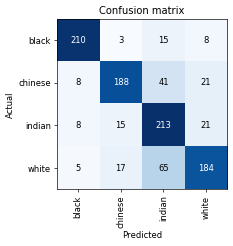

In [42]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

## Split other datasets

In [61]:
icao_label_path = Path('../data/icao/mouthopen_celeba/')
out_label_path = Path('../data/icao/mouthopen_celeba_black/')
errors = 0
for path in progress_bar(get_image_files(icao_label_path, recurse=True)):
    try:
        im_label_path = Path('/'.join(str(path).split('/')[-2:]))
        im = open_image(path)
        o,_,out_tensor = learner.predict(im)
        if o.obj == 'black': im.save(out_label_path/im_label_path)
    except: errors += 1
errors

0